In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import json
import subprocess
import datetime

from pathlib import Path
from scipy.io import loadmat, savemat

In [2]:
N = 2**7 + 1  # Example value; adjust as needed
dt = 1e-4  # Example value; adjust as needed
T_end = 1  # Example value; adjust as needed
# mus = "0.01:0.01:0.1"  # MATLAB array syntax
Mp = 10
K = T_end / dt
DS = 1

In [3]:
# define perturbations to the nominal parameter mu=0.01. Perturbations of +-0.001% and +-0.01% are considered.
nominal_mu = 0.01
# perturbations in percentage
perturbations1 = [0.001, 0.01]
perturbations2 = [0.0001, 0.0005]

mus1 = [nominal_mu * (1 + pert) for pert in perturbations1] + [nominal_mu * (1 - pert) for pert in perturbations1]
mus2 = [nominal_mu * (1 + pert) for pert in perturbations2] + [nominal_mu * (1 - pert) for pert in perturbations2]

In [4]:
import json

datapath = '/data1/jy384/research/Data/UnimodalSROB/Burgers/'
srcpath = '/home/jy384/projects/UnimodalSROB/examples/burgers/'


# generate number UID based on perturbations, by creating a number based on the perturbations
scaling = 1e-6
uid1 = str('_'.join([str(int(pert * 1/scaling)) for pert in perturbations1]))
uid2 = str('_'.join([str(int(pert * 1/scaling)) for pert in perturbations2]))

In [5]:
# Read s_ref_all.mat and s_rec_all.mat
reconstructedState_path = Path(datapath) / 'reconstructedState'
referenceState_path = Path(datapath) / 'referenceState'

s_rec_all_lst = []
s_ref_all_lst = []

for uid in [uid1, uid2]:
    s_ref_all = loadmat(f'{referenceState_path}/s_ref_all_nominalmu_{int(nominal_mu *1/scaling)}_perturb_{uid}.mat')['s_ref_all']
    s_rec_all = loadmat(f'{reconstructedState_path}/s_rec_all_nominalmu_{int(nominal_mu * 1/scaling)}_perturb_{uid}.mat')['s_rec_all']
    
    s_ref_all = np.array([s_ref_all[i][0] for i in range(s_ref_all.shape[0])])
    s_rec_all = np.array([s_rec_all[i][0] for i in range(s_rec_all.shape[0])])
    
    s_rec_all_lst.append(s_rec_all)
    s_ref_all_lst.append(s_ref_all)
    
# Concatenate the two perturbations
s_rec_all = np.concatenate(s_rec_all_lst)
s_ref_all = np.concatenate(s_ref_all_lst)

print(s_rec_all.shape, s_ref_all.shape)

(8, 129, 10001) (8, 129, 10001)


In [6]:
# get standard deviation of the reconstructed state
stds = np.std(s_rec_all, axis=0)
print("stds = ", stds.shape)

# load nominal state by finding the file with name containing 'mu_0.01' using glob
nominalState_path = list(Path(datapath).rglob(f's_ref_all_mu_{nominal_mu}_*'))
nominalState = loadmat(nominalState_path[0])['s_ref_all']

# only get the first element of the cell array
nominalState = nominalState[0][0]
print("nominalState = ", nominalState.shape)

stds =  (129, 10001)
nominalState =  (129, 10001)


X =  (129, 10001)
Y =  (129, 10001)
nominalState =  (129, 10001)


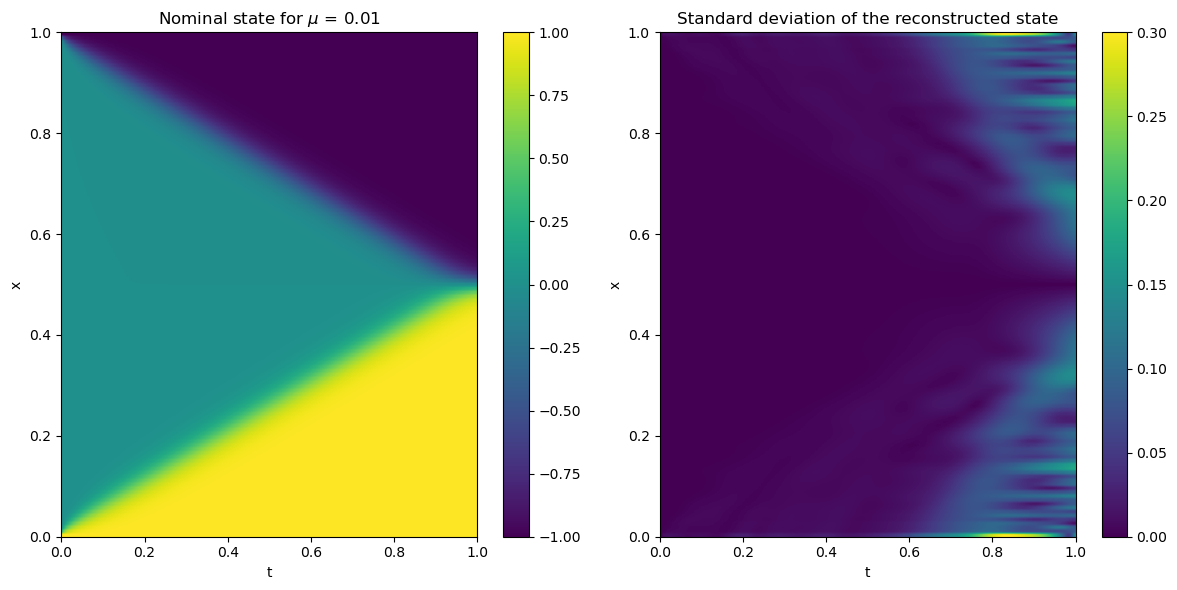

In [7]:
# plot the standard deviation of the reconstructed state on the right side of the nominal state
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
X, Y = np.meshgrid(np.linspace(0.0, T_end, int(K+1)), np.linspace(0.0, 1.0, N))
print("X = ", X.shape)
print("Y = ", Y.shape)
print("nominalState = ", nominalState.shape)
# s = ax.plot_surface(X, Y, s_ref_all[i].reshape(N, int(K+1)), cmap='viridis')
c1 = axs[0].imshow(nominalState.reshape(N, int(K+1)), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower', aspect='auto')
# color bar for the nominal state plot by getting the minimum and maximum values of the nominal state
vmin = np.min(nominalState)
vmax = np.max(nominalState)
c1.set_clim(vmin=vmin, vmax=vmax)
fig.colorbar(c1)

axs[0].set_xlabel('t')
axs[0].set_ylabel('x')
axs[0].set_title(f'Nominal state for $\mu$ = {nominal_mu}')

c2 = axs[1].imshow(stds.reshape(N, int(K+1)), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower', aspect='auto')

fig.colorbar(c2)
axs[1].set_xlabel('t')
axs[1].set_ylabel('x')
axs[1].set_title(f'Standard deviation of the reconstructed state')

plt.tight_layout()
plt.show()


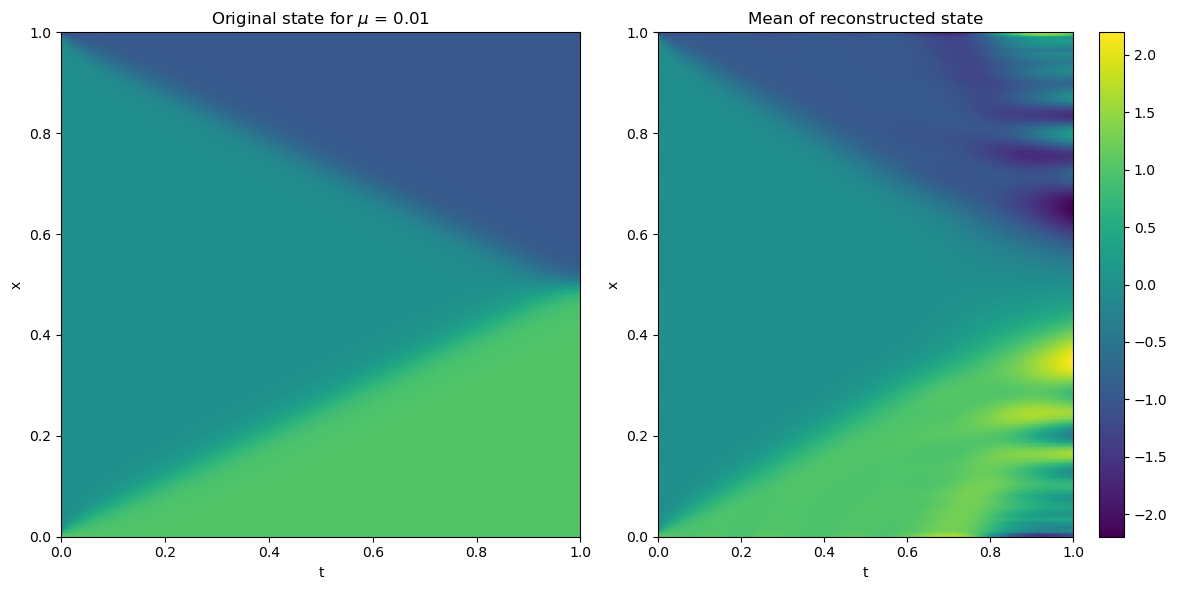

In [12]:
# Plot the original state
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
c1 = axs[0].imshow(nominalState.reshape(N, int(K+1)), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower', aspect='auto')
c1.set_clim(vmin=vmin, vmax=vmax)

axs[0].set_xlabel('t')
axs[0].set_ylabel('x')
axs[0].set_title(f'Original state for $\mu$ = {nominal_mu}')

# Plot the mean state
mean_state = np.mean(s_rec_all, axis=0)
c2 = axs[1].imshow(mean_state.reshape(N, int(K+1)), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower', aspect='auto')
# color bar for both plots by getting the minimum and maximum values of the mean state
vmin = np.min(mean_state)
vmax = np.max(mean_state)
c2.set_clim(vmin=vmin, vmax=vmax)

fig.colorbar(c2)

axs[1].set_xlabel('t')
axs[1].set_ylabel('x')
axs[1].set_title('Mean of reconstructed state')

plt.tight_layout()
plt.show()
